In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt

import glob
from pathlib import Path

from scipy.stats import pearsonr

## Load Bacterial SwissProt

In [2]:
swiss_df = pd.read_hdf('../data/bacterial_swissprot.h5')
swiss_df.head()

,accessions,sequence_length,sequence,description,InterPro,GO,KO,Gene3D,Pfam,KEGG,...,Superkingdom,Kingdom,Phylum,Class,Order,Family,Subfamily,Genus,Species,Transmembrane
entry_name,,,,,,,,,,,,,,,,,,,,,
12AH_CLOS4,P21215,29.0,MIFDGKVAIITGGGKAKSIGYGIAVAYAK,RecName: Full=12-alpha-hydroxysteroid dehydrog...,IPR036291,GO:0047013||GO:0030573||GO:0016042,NaN,NaN,NaN,NaN,...,Bacteria,NaN,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,NaN,Clostridium,NaN,0.0
12KD_MYCSM,P80438,24.0,MFHVLTLTYLCPLDVVXQTRPAHV,RecName: Full=12 kDa protein; Flags: Fragment;,NaN,NaN,NaN,NaN,NaN,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,NaN,Mycolicibacterium,NaN,0.0
12OLP_LISIN,Q92AT0,1086.0,MTMLKEIKKADLSAAFYPSGELAWLKLKDIMLNQVIQNPLENRLSQ...,"RecName: Full=1,2-beta-oligoglucan phosphoryla...",IPR008928||IPR012341||IPR033432,GO:0016740,K21298,1.50.10.10,PF17167,lin:lin1839,...,Bacteria,NaN,Firmicutes,Bacilli,Bacillales,Listeriaceae,NaN,Listeria,NaN,NaN
12S_PROFR,Q8GBW6||Q05617,611.0,MAENNNLKLASTMEGRVEQLAEQRQVIEAGGGERRVEKQHSQGKQT...,RecName: Full=Methylmalonyl-CoA carboxyltransf...,IPR034733||IPR000438||IPR029045||IPR011763||IP...,GO:0009317||GO:0003989||GO:0047154||GO:0006633,NaN,NaN,PF01039,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Propionibacteriales,Propionibacteriaceae,NaN,Propionibacterium,NaN,0.0
14KD_MYCBO,P0A5B8||A0A1R3Y251||P30223||X2BJK6,144.0,MATTLPVQRHPRSLFPEFSELFAAFPSFAGLRPTFDTRLMRLEDEM...,RecName: Full=14 kDa antigen; AltName: Full=16...,IPR002068||IPR008978,GO:0005618||GO:0005576,NaN,2.60.40.790,PF00011,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,NaN,Mycobacterium,NaN,0.0


## Load Label Recovery Results

In [3]:
results_path = Path('../01-label-recovery/results_ArdiMiPE/')

rec = pd.concat({
        path.stem:
        pd.read_csv(path) for path in results_path.glob('*/*.csv')
}).reset_index(level=0)
rec = rec[~rec['level_0'].isin(['Phylum', 'Genus', 'Order', 'Family'])]
rec.head()

,level_0,entry_name,k=3,k=15,k=51
0,Pfam,12OLP_LISIN,0.00,0.0,0.0
1,Pfam,12S_PROFR,1.00,0.0,0.0
2,Pfam,14KD_MYCBO,1.00,1.0,0.0
3,Pfam,14KL_BRUA1,0.25,0.0,0.0
4,Pfam,14KL_OCHA4,0.25,0.0,0.0


In [4]:
rec = rec.groupby('entry_name').mean()
swiss_df['REE'] = 1 - rec['k=51']

In [5]:
annotations = [
    'InterPro',
    'GO',
    'KO',
    'Pfam',
    'SUPFAM',
    'EC number',
    'Gene3D',
]

## Count log-averaged size of the functional classes

In [6]:
a_counts = []
for a in annotations:
    name = f'{a}_count'
    swiss_df[name] = swiss_df[a].map(swiss_df[a].value_counts().to_dict())
    
    a_counts.append(name)

In [7]:
swiss_df['log_averaged_class_size'] = np.log(swiss_df[a_counts]).mean(axis=1)

In [8]:
sdf = swiss_df[swiss_df['log_averaged_class_size'].notnull() & swiss_df['REE'].notnull()]
r, p = pearsonr(sdf['log_averaged_class_size'], sdf['REE'])

print(f'Pearson R: {r}, p-value: {p}, N: {len(sdf)}')

Pearson R: -0.7276199097715365, p-value: 0.0, N: 200115


### Plot 

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x576 with 0 Axes>

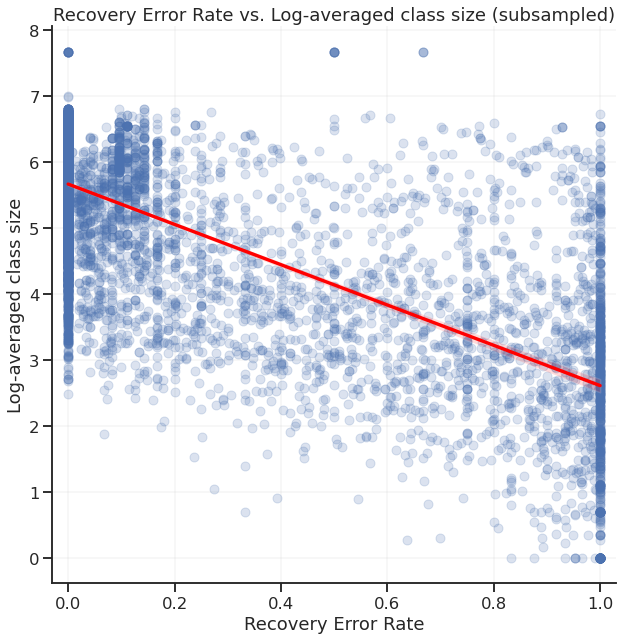

In [9]:
sns.set('talk', 'ticks')
plt.figure(figsize=(12,8))
# sns.histplot(swiss_df, x="rec_error", y="mean_class_size")
sns.lmplot(data=swiss_df.sample(10000), x="REE", y="log_averaged_class_size", size=9, scatter_kws=dict(alpha=0.2), ci=99, line_kws=dict(color='red'))
plt.xlim(-0.03, 1.03)

plt.title('Recovery Error Rate vs. Log-averaged class size (subsampled)')
plt.xlabel('Recovery Error Rate')
plt.ylabel('Log-averaged class size')
plt.grid(alpha=0.2)

## Unknown words

In [10]:
swiss_df['is_uncharacterized'] = swiss_df['description'].str.lower().str.contains('uncharacterized')
swiss_df['is_putative'] = swiss_df['description'].str.lower().str.contains('putative')
swiss_df['is_probable'] = swiss_df['description'].str.lower().str.contains('probable')

In [11]:
swiss_df['is_known'] = ((swiss_df['is_uncharacterized'] + swiss_df['is_putative'] + swiss_df['is_probable']).astype('float') > 0).map({True: 'Unknown',  False: "Known"})

In [12]:
n_labels = 10
labels = [f'{i/n_labels}-{(i+1)/n_labels}' for i in range(n_labels)]
swiss_df['REE_cat'] = pd.cut(swiss_df['REE'], n_labels, labels=labels)

In [13]:
counts = swiss_df.groupby('REE_cat')['is_known'].value_counts().unstack()

counts['putative'] = swiss_df.groupby('REE_cat')['is_putative'].value_counts().unstack()[True]
counts['probable'] = swiss_df.groupby('REE_cat')['is_probable'].value_counts().unstack()[True]
counts['uncharacterized'] = swiss_df.groupby('REE_cat')['is_uncharacterized'].value_counts().unstack()[True]

counts['total'] = counts['Known'] + counts['Unknown']
counts['unknown_prc'] = counts['Unknown'] / counts['total'] * 100
counts['putative_prc'] = counts['putative'] / counts['total'] * 100
counts['probable_prc'] = counts['probable'] / counts['total'] * 100
counts['uncharacterized_prc'] = counts['uncharacterized'] / counts['total'] * 100
# counts = counts.reset_index().melt(id_vars=['rec_cat'], value_vars=['unknown_prc'] value_name='count')
counts

is_known,Known,Unknown,putative,probable,uncharacterized,total,unknown_prc,putative_prc,probable_prc,uncharacterized_prc
REE_cat,,,,,,,,,,
0.0-0.1,135422,5708,2013,3159,540,141130,4.044498,1.426345,2.238362,0.382626
0.1-0.2,9856,888,429,280,179,10744,8.265078,3.992926,2.606106,1.666046
0.2-0.3,3610,594,191,208,195,4204,14.129401,4.543292,4.947669,4.638440
0.3-0.4,3207,637,179,206,254,3844,16.571280,4.656608,5.359001,6.607700
0.4-0.5,3447,648,206,159,285,4095,15.824176,5.030525,3.882784,6.959707
0.5-0.6,3064,491,164,150,177,3555,13.811533,4.613221,4.219409,4.978903
0.6-0.7,3290,791,237,199,359,4081,19.382504,5.807400,4.876256,8.796864
0.7-0.8,3939,840,220,196,428,4779,17.576899,4.603474,4.101276,8.955849
0.8-0.9,3824,647,198,262,190,4471,14.471036,4.428539,5.859987,4.249609


In [14]:
counts = counts.reset_index().melt(
    id_vars=['REE_cat'],
    var_name='kind',
    value_vars=['unknown_prc', 'putative_prc', 'probable_prc', 'uncharacterized_prc'],
    value_name='prc'
)

In [15]:
palette = [
    "#8d5eac",
    "#3b66b6",
    "#d3759e",
    "#2fc7bd",
]

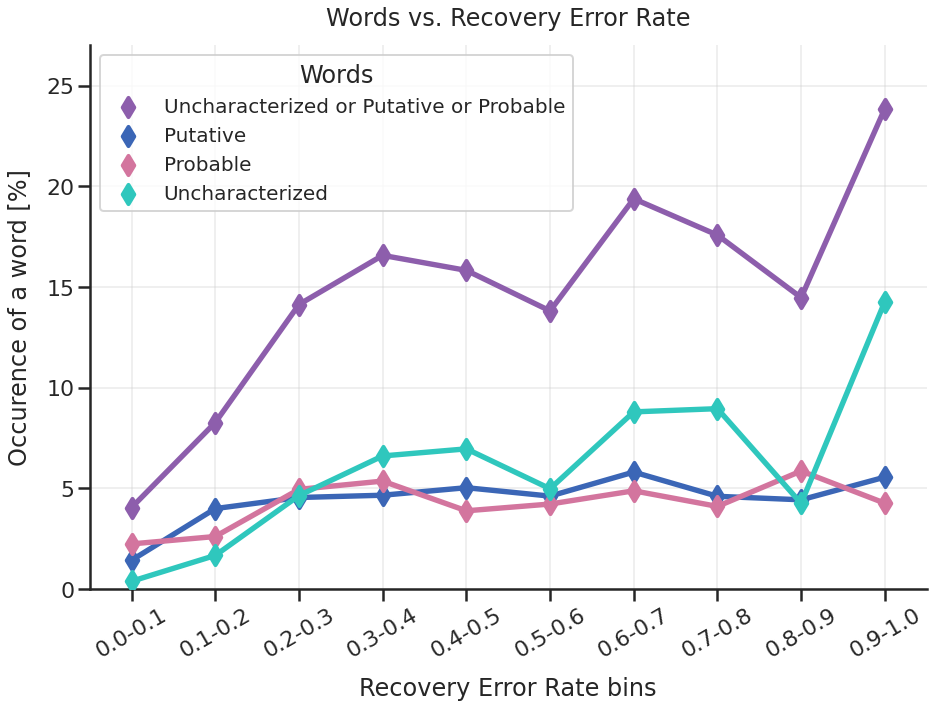

In [16]:
sns.set('poster', 'ticks')
plt.figure(figsize=(15, 10))
sns.pointplot(data=counts.reset_index(), x='REE_cat', y='prc', hue='kind', markers='d', palette=palette)
plt.grid(alpha=0.3)
sns.despine()
plt.xlabel('Recovery Error Rate bins', labelpad=15)
plt.ylabel('Occurence of a word [%]', labelpad=15)
plt.title('Words vs. Recovery Error Rate', pad=20)
plt.xticks(rotation=30)
plt.ylim(0, 27)

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(
    title='Words',
    handles=handles,
    labels=['Uncharacterized or Putative or Probable', 'Putative' ,'Probable', 'Uncharacterized'],
    fontsize=20
#     loc=''
)